In [3]:
import numpy as np 
import pandas as pd 
import bz2 
import re 
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


print(os.listdir("../input"))

/kaggle/input/amazonreviews/test.ft.txt.bz2
/kaggle/input/amazonreviews/train.ft.txt.bz2
['amazonreviews']


In [4]:
train_file = bz2.BZ2File('../input/amazonreviews/train.ft.txt.bz2')
test_file = bz2.BZ2File('../input/amazonreviews/test.ft.txt.bz2')

In [5]:
train_file_lines = train_file.readlines()
test_file_lines = test_file.readlines()

In [6]:
# clean the older variables
del train_file, test_file
gc.collect()

44

In [7]:
train_file_lines = [x.decode('utf-8') for x in train_file_lines]
test_file_lines = [x.decode('utf-8') for x in test_file_lines]

In [8]:
print(type(train_file_lines), type(test_file_lines), "\n")

print("Train Data Volume:", len(train_file_lines), "\n")
print("Test Data Volume:", len(test_file_lines), "\n\n")

print("Demo: ", "\n")
for x in train_file_lines[:2]:
    print(x, "\n")

<class 'list'> <class 'list'> 

Train Data Volume: 3600000 

Test Data Volume: 400000 


Demo:  

__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
 

__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, t

In [9]:
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file_lines]

In [10]:
train_labels[0]

1

Text(0.5, 1.0, 'Train Labels distribution')

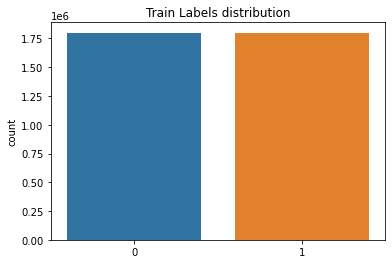

In [9]:
sns.countplot(train_labels)
plt.title('Train Labels distribution')

Text(0.5, 1.0, 'Test Labels distribution')

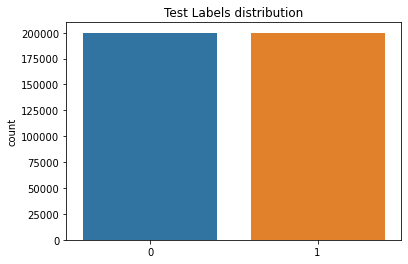

In [10]:
sns.countplot(test_labels)
plt.title('Test Labels distribution')

In [11]:
train_sentences = [x.split(' ', 1)[1][:-1] for x in train_file_lines]
test_sentences = [x.split(' ', 1)[1][:-1] for x in test_file_lines]

In [12]:
train_sentences[0]

'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [15]:
print(train_sentences[:2])
train_labels[:2]

['Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^', "The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny."]


[1, 1]

In [16]:
import tensorflow as tf

In [17]:
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus_available)
assert num_gpus_available > 0

Num GPUs Available:  0


AssertionError: 

Text(0.5, 1.0, 'Word Frequency Distribution in Reviews')

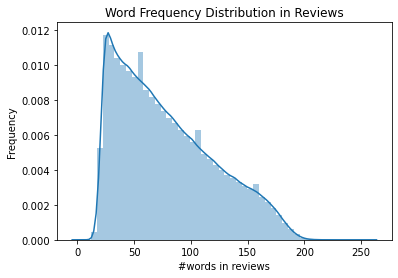

In [13]:
train_sentences_size = list(map(lambda x: len(x.split()), train_sentences))

sns.distplot(train_sentences_size)
plt.xlabel("#words in reviews")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution in Reviews")

In [14]:
train_label_len = pd.DataFrame({"labels": train_labels, "len": train_sentences_size})
train_label_len.head()

,labels,len
0,1,80
1,1,97
2,1,129
3,1,118
4,1,87


Negative mean length: 81.50
Positive mean length: 75.46
Mean Difference: 6.04


Text(0.5, 1.0, 'Review Size Categorization')

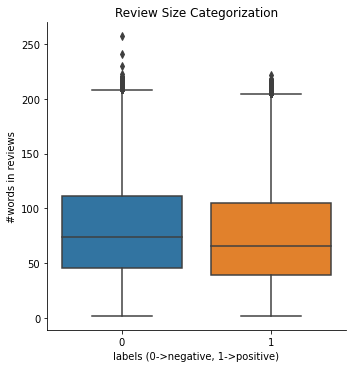

In [15]:
neg_mean_len = train_label_len.groupby('labels')['len'].mean().values[0]
pos_mean_len = train_label_len.groupby('labels')['len'].mean().values[1]

print(f"Negative mean length: {neg_mean_len:.2f}")
print(f"Positive mean length: {pos_mean_len:.2f}")
print(f"Mean Difference: {neg_mean_len-pos_mean_len:.2f}")
sns.catplot(x='labels', y='len', data=train_label_len, kind='box')
plt.xlabel("labels (0->negative, 1->positive)")
plt.ylabel("#words in reviews")
plt.title("Review Size Categorization")

In [16]:
del neg_mean_len,pos_mean_len
gc.collect()

22

In [17]:
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])

for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])

In [18]:
list(filter(lambda x: '<url>' in x, train_sentences))[0]

"Bad Deal!!: I ordered this DVD and received a substitute I never received the DVD I ordered from Importcds (the Vendor). I contacted them and did not recieve any feedback. I can't rate a DVD I have never seen. I didn't bother to send it back because it would have cost me more that I orginally paid for it. In the future I will watch for the name of the person and/or persons I am buying from. I thought they were a good company. I understand a simple mistake but, to not get a response at all is not good businees sense. I spend hundreds of dollars a month on <url> building my DVD collection. I guess I will be more careful in the future."

In [19]:
del train_file_lines, test_file_lines
gc.collect()

66

In [20]:
import nltk
from nltk import pos_tag
from nltk import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation

nltk.download('averaged_perceptron_tagger')

wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

lemmatize_sent('He is WALKING walking to school')

[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno -3] Temporary failure in name resolution>


['he', 'be', 'walking', 'walk', 'to', 'school']

In [21]:
# Stopwords from stopwords-json
stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
stopwords_json_en = set(stopwords_json['en'])
stopwords_nltk_en = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
# Combine the stopwords. Its a lot longer so I'm not printing it out...
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en, stopwords_punct)

In [22]:
def preprocess_text(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    return [word for word in lemmatize_sent(text) 
            if word not in stoplist_combined
            and not word.isdigit()]

In [23]:
train_sentences[10]

"The Worst!: A complete waste of time. Typographical errors, poor grammar, and a totally pathetic plot add up to absolutely nothing. I'm embarrassed for this author and very disappointed I actually paid for this book."

In [24]:
preprocess_text(train_sentences[10])

['bad',
 'complete',
 'waste',
 'time',
 'typographical',
 'error',
 'poor',
 'grammar',
 'totally',
 'pathetic',
 'plot',
 'add',
 'absolutely',
 "'m",
 'embarrassed',
 'author',
 'disappointed',
 'pay',
 'book']

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(analyzer=preprocess_text)

In [26]:
train_set = count_vect.fit_transform(train_sentences[:10000])

In [27]:
train_set.toarray().shape

(10000, 33153)

In [28]:
test_set = count_vect.transform(test_sentences[:1000])

hello 


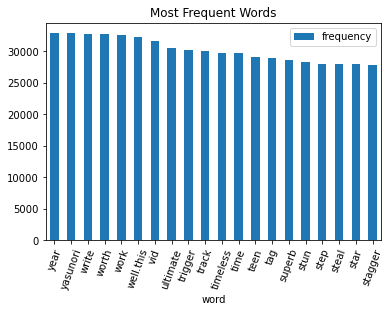

In [29]:
most_freq_words = pd.DataFrame(count_vect.vocabulary_.items(), columns=['word', 'frequency'])[:100].sort_values(ascending=False, by = "frequency")[:20]
most_freq_words.plot.bar(x="word", y="frequency", rot=70, title="Most Frequent Words")
print('hello ')


In [42]:
from sklearn.metrics import accuracy_score

In [48]:
#NB
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(train_set, train_labels[:10000])
predictions_valid = clf.predict(test_set)
print('Amazon Sentiment Analysis Accuracy = {}'.format(accuracy_score(predictions_valid, test_labels[:1000]) * 100))

Amazon Sentiment Analysis Accuracy = 82.89999999999999


In [49]:
#LR
from sklearn.linear_model import LogisticRegression 
classifier= LogisticRegression(solver='lbfgs', max_iter=1000)
classifier.fit(train_set, train_labels[:10000])
predictions_valid = classifier.predict(test_set)
print('Amazon Sentiment Analysis Accuracy = {}'.format(accuracy_score(predictions_valid, test_labels[:1000]) * 100)) 

Amazon Sentiment Analysis Accuracy = 83.89999999999999


In [50]:
#RF
from sklearn.ensemble import RandomForestClassifier
classifier= RandomForestClassifier(n_estimators= 10, criterion="entropy")  
classifier.fit(train_set, train_labels[:10000])
predictions_valid = classifier.predict(test_set)
print('Amazon Sentiment Analysis Accuracy = {}'.format(accuracy_score(predictions_valid, test_labels[:1000]) * 100)) 

Amazon Sentiment Analysis Accuracy = 78.10000000000001


In [ ]:
from sklearn.svm import SVC # "Support vector classifier"  
classifier = SVC(kernel='linear', random_state=0)  
classifier.fit(x_train, y_train)  

In [33]:
def important_features(vectorizer,classifier,n=40):
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()

    topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:n]

    class1_frequency_dict = {}
    class2_frequency_dict = {}
    
    for coef, feat in topn_class1:
        class1_frequency_dict.update( {feat : coef} )

    for coef, feat in topn_class2:
        class2_frequency_dict.update( {feat : coef} )

    return (class1_frequency_dict, class2_frequency_dict)

In [34]:
neg_frequency_dict, pos_frequency_dict = important_features(count_vect, clf)

In [35]:
neg_feature_freq = pd.DataFrame(neg_frequency_dict.items(), columns = ["feature_word", "frequency"])  
pos_feature_freq = pd.DataFrame(pos_frequency_dict.items(), columns = ["feature_word", "frequency"])  

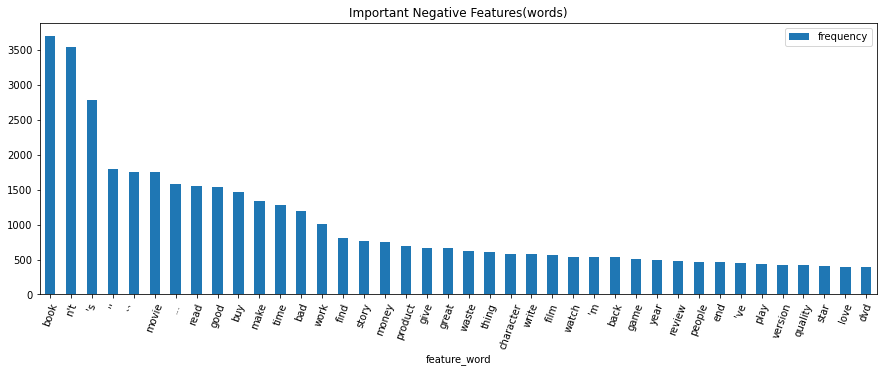

In [36]:
neg_feature_freq.plot.bar(x="feature_word", y="frequency", rot=70, figsize=(15, 5), title="Important Negative Features(words)")

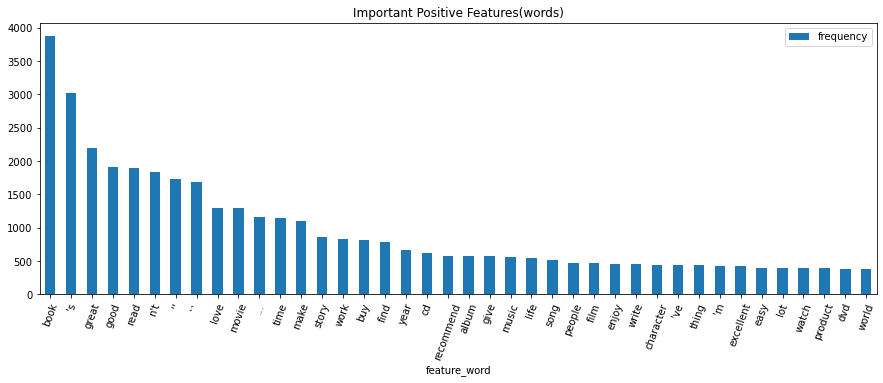

In [37]:
pos_feature_freq.plot.bar(x="feature_word", y="frequency", rot=70, figsize=(15, 5), title="Important Positive Features(words)")